#📌 Extracão

In [2]:
import requests

url = "https://raw.githubusercontent.com/mouratsm/challenge-telecom-x/main/TelecomX_Data.json"
resposta = requests.get(url)
dados = resposta.json()

print(f"Tipo dos dados: {type(dados)}")
print("Exemplo de registro:")
print(dados[0])


Tipo dos dados: <class 'list'>
Exemplo de registro:
{'customerID': '0002-ORFBO', 'Churn': 'No', 'customer': {'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 9}, 'phone': {'PhoneService': 'Yes', 'MultipleLines': 'No'}, 'internet': {'InternetService': 'DSL', 'OnlineSecurity': 'No', 'OnlineBackup': 'Yes', 'DeviceProtection': 'No', 'TechSupport': 'Yes', 'StreamingTV': 'Yes', 'StreamingMovies': 'No'}, 'account': {'Contract': 'One year', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Mailed check', 'Charges': {'Monthly': 65.6, 'Total': '593.3'}}}


#🔧 Transformação

In [3]:

import pandas as pd

# Flatten dos dados aninhados
registros_flat = []
for cliente in dados:
    base = {
        "customerID": cliente.get("customerID"),
        "Churn": cliente.get("Churn")
    }
    base.update(cliente.get("customer", {}))
    base.update(cliente.get("phone", {}))
    base.update(cliente.get("internet", {}))
    base.update(cliente.get("account", {}))
    registros_flat.append(base)

df = pd.DataFrame(registros_flat)

# Funções para conversão segura das colunas dentro de Charges
def safe_float_total(x):
    if isinstance(x, dict):
        v = x.get("Total", 0)
        try:
            return float(v.strip()) if isinstance(v, str) else float(v)
        except:
            return 0.0
    return 0.0

def safe_float_monthly(x):
    if isinstance(x, dict):
        v = x.get("Monthly", 0)
        try:
            return float(v.strip()) if isinstance(v, str) else float(v)
        except:
            return 0.0
    return 0.0

# Aplicar as funções para extrair as colunas numéricas
df["MonthlyCharges"] = df["Charges"].apply(safe_float_monthly)
df["TotalCharges"] = df["Charges"].apply(safe_float_total)

# Remover coluna original que não será mais usada
df.drop(columns=["Charges"], inplace=True)

# Remover registros com valor vazio na coluna Churn
df = df[df["Churn"].str.strip() != ""]

print("Colunas do DataFrame após transformação:")
print(df.columns.tolist())

df.head()



Colunas do DataFrame após transformação:
['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


#📊 Carga e análise

In [6]:
# Ajustar tipos numéricos
df["tenure"] = pd.to_numeric(df["tenure"], errors='coerce')
df["MonthlyCharges"] = pd.to_numeric(df["MonthlyCharges"], errors='coerce')
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Estatísticas descritivas
print("Estatísticas descritivas:")
print(df.describe())

# Contagem e percentual de Churn
print("\nContagem de churn:")
print(df["Churn"].value_counts())

print("\nPercentual de churn:")
print(df["Churn"].value_counts(normalize=True) * 100)

Estatísticas descritivas:
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

Contagem de churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Percentual de churn:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


#📄Relatorio Final

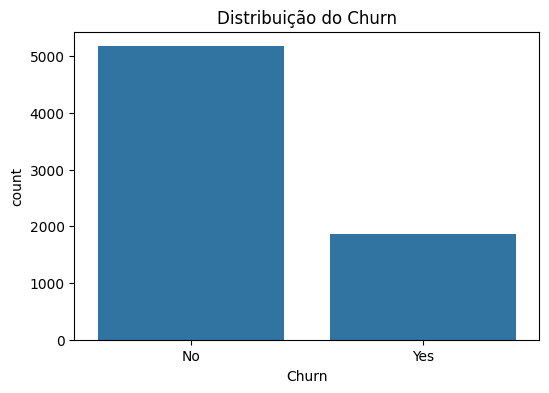

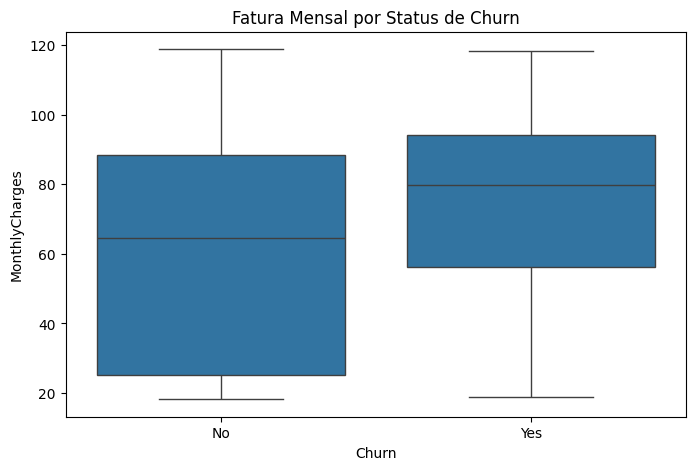

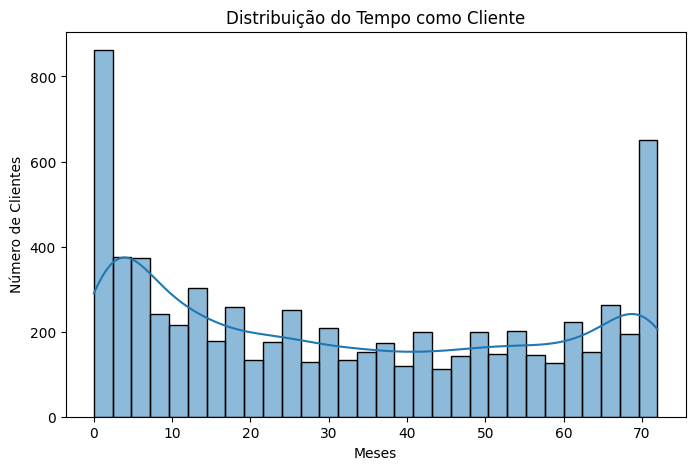

Total de clientes: 7043
Clientes com churn: 1869
Taxa de churn: 26.54%


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuição do Churn
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Distribuição do Churn")
plt.show()

# Boxplot de MonthlyCharges por Churn
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Fatura Mensal por Status de Churn")
plt.show()

# Histograma do tempo de contrato (tenure)
plt.figure(figsize=(8,5))
sns.histplot(df["tenure"], bins=30, kde=True)
plt.title("Distribuição do Tempo como Cliente")
plt.xlabel("Meses")
plt.ylabel("Número de Clientes")
plt.show()

# Insights rápidos
total_clientes = len(df)
clientes_churn = df["Churn"].value_counts().get("Yes", 0)
taxa_churn = clientes_churn / total_clientes * 100

print(f"Total de clientes: {total_clientes}")
print(f"Clientes com churn: {clientes_churn}")
print(f"Taxa de churn: {taxa_churn:.2f}%")


Métricas numéricas agrupadas por churn:
          tenure                   MonthlyCharges                     \
            mean median        std           mean  median        std   
Churn                                                                  
No     37.569965   38.0  24.113777      61.265124  64.425  31.092648   
Yes    17.979133   10.0  19.531123      74.441332  79.650  24.666053   

      TotalCharges                         
              mean    median          std  
Churn                                      
No     2549.911442  1679.525  2329.954215  
Yes    1531.796094   703.550  1890.822994  


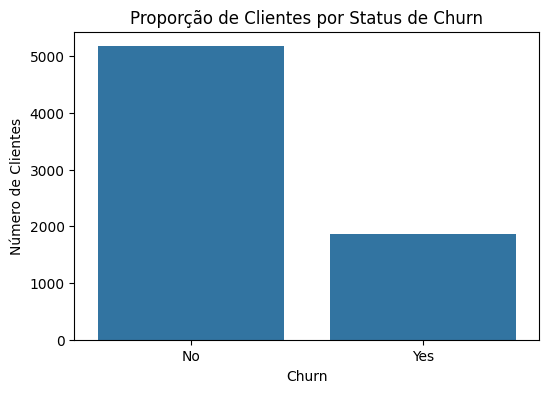

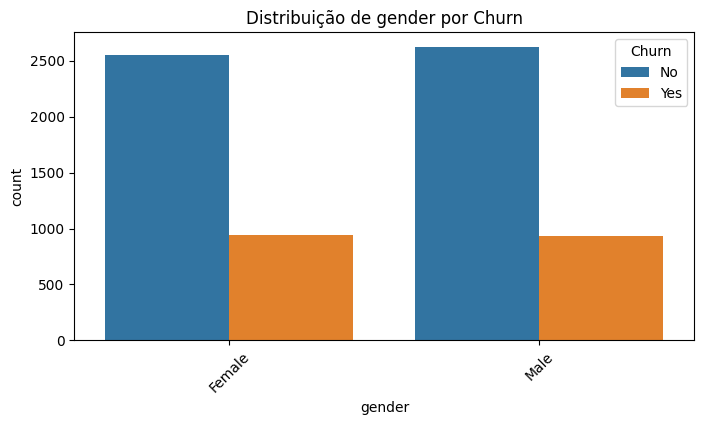

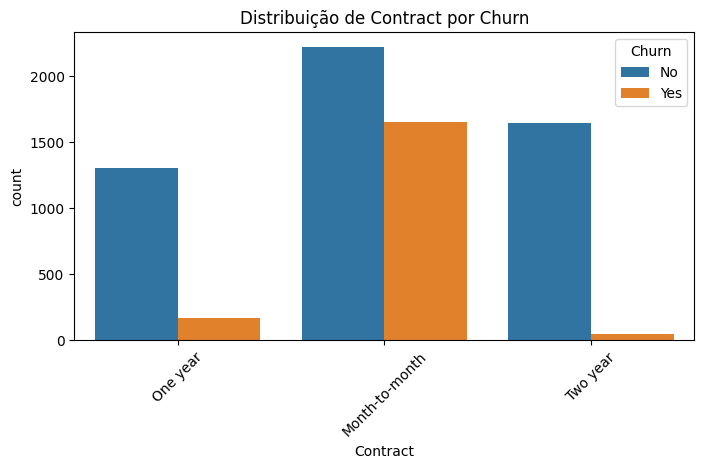

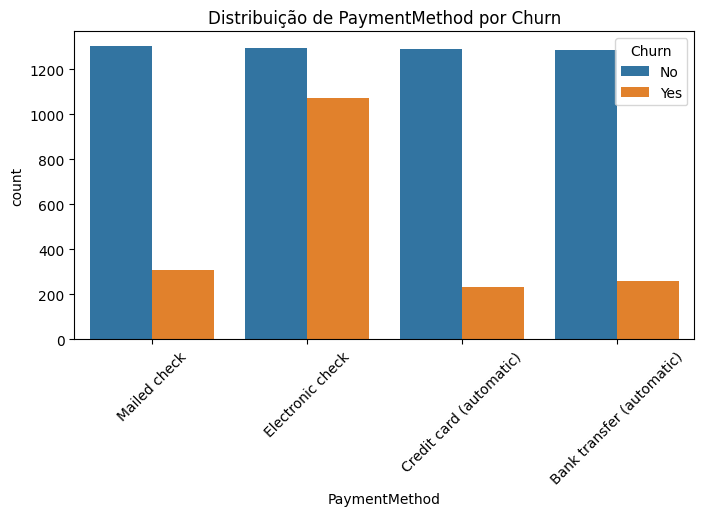

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estatísticas descritivas numéricas por churn
print("Métricas numéricas agrupadas por churn:")
stats = df.groupby("Churn")[["tenure", "MonthlyCharges", "TotalCharges"]].agg(["mean", "median", "std"])
print(stats)

# Gráfico de proporção de churn
plt.figure(figsize=(6,4))
sns.countplot(x="Churn", data=df)
plt.title("Proporção de Clientes por Status de Churn")
plt.xlabel("Churn")
plt.ylabel("Número de Clientes")
plt.show()

# Função para plotar variáveis categóricas vs churn
def plot_categorical(var):
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=var, hue="Churn")
    plt.title(f"Distribuição de {var} por Churn")
    plt.xticks(rotation=45)
    plt.show()

# Variáveis categóricas para analisar
categorical_vars = ["gender", "Contract", "PaymentMethod"]

for var in categorical_vars:
    plot_categorical(var)


📌 1. Tempo como cliente (tenure)

Sem churn: média de ~38 meses

Com churn: média de ~18 meses

➡ Clientes que saem ficam, em média, menos da metade do tempo comparados aos que permanecem. Isso reforça que os primeiros dois anos são críticos.

📌 2. Valor da fatura mensal (MonthlyCharges)

Sem churn: média ~R$ 61,27


Com churn: média ~R$ 74,44

➡ Clientes com faturas mais altas tendem a cancelar mais. Isso pode indicar sensibilidade a preço ou insatisfação com custo-benefício.

📌 3. Valor total já pago (TotalCharges)

Sem churn: média ~R$ 2.549


Com churn: média ~R$ 1.532

➡ Clientes que permanecem já investiram mais na empresa, enquanto clientes que saem têm gasto acumulado menor — reforça o padrão de cancelamento precoce.

💡 Conclusões estratégicas


Retenção precoce: investir em ações nos primeiros meses de contrato (benefícios iniciais, suporte dedicado, acompanhamento personalizado).


Planos acessíveis: criar opções de planos mais baratos ou benefícios para clientes com faturas mais altas.

Relacionamento com clientes fiéis: oferecer vantagens a quem já tem longo tempo de contrato, para evitar migração para concorrência.